<a href="https://colab.research.google.com/github/mamontovatetiana/MyJupyterNotebooks./blob/main/%D0%9C%D0%B0%D0%BC%D0%BE%D0%BD%D1%82%D0%BE%D0%B2%D0%B0_%D0%A2_%D0%92_%D0%90%D0%A4%D0%95%D0%A0_%D0%9F%D0%A0_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

        date  cycle_day  bbt_celsius
0 2025-01-01          1        36.57
1 2025-01-02          2        36.54
2 2025-01-03          3        36.58
3 2025-01-04          4        36.63
4 2025-01-05          5        36.54
5 2025-01-06          6        36.54
6 2025-01-07          7        36.63
7 2025-01-08          8        36.59
8 2025-01-09          9        36.53
9 2025-01-10         10        36.58


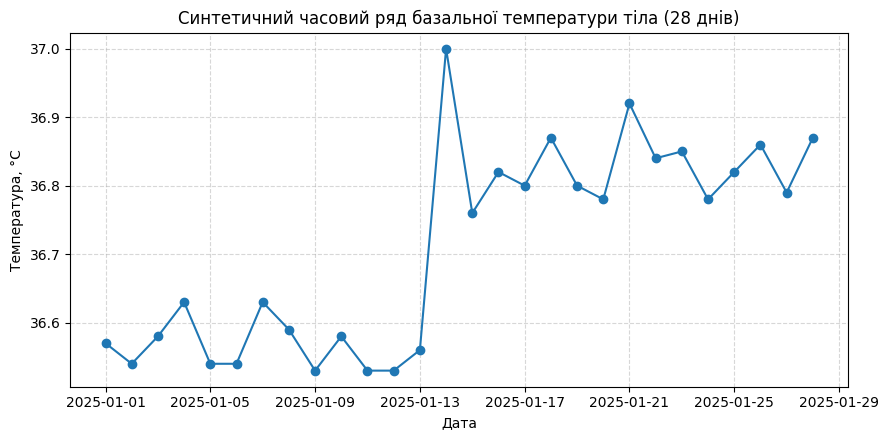

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

np.random.seed(42)

# Параметри
n_days = 28
start_date = datetime(2025, 1, 1)

follicular_base = 36.55  # °C
luteal_base = 36.85      # °C
ovulation_spike = 0.25   # °C
noise_sigma = 0.05       # шум

days = np.arange(1, n_days + 1)
temps = np.empty(n_days, dtype=float)

# Фолікулярна фаза (1–13 дні)
temps[:13] = follicular_base

# Овуляція (14-й день)
temps[13] = luteal_base + ovulation_spike

# Лютеїнова фаза (15–28 дні)
temps[14:] = luteal_base

# Додаємо шум
temps = temps + np.random.normal(0, noise_sigma, size=n_days)

# Формуємо датафрейм
dates = [start_date + timedelta(days=int(d - 1)) for d in days]
df = pd.DataFrame({
    "date": dates,
    "cycle_day": days,
    "bbt_celsius": temps.round(2)
})

# Збереження у робочу директорію Colab
csv_path = "bbt_cycle_28d.csv"
df.to_csv(csv_path, index=False)

# Виведення перших 10 рядків
print(df.head(10))

# Графік
plt.figure(figsize=(9, 4.5))
plt.plot(df["date"], df["bbt_celsius"], marker="o")
plt.title("Синтетичний часовий ряд базальної температури тіла (28 днів)")
plt.xlabel("Дата")
plt.ylabel("Температура, °C")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
# Перевірка пропусків (NaN) у вже наявному DataFrame df
nan_summary = {
    "total_values": df["bbt_celsius"].size,
    "nan_count": int(df["bbt_celsius"].isna().sum()),
    "nan_fraction": float(df["bbt_celsius"].isna().mean())  # частка (0..1)
}
nan_summary


{'total_values': 28, 'nan_count': 0, 'nan_fraction': 0.0}

Пропуски внесено у такі індекси: [23 15]
Підсумок після внесення пропусків: {'total_values': 28, 'nan_count': 2, 'nan_fraction': 0.07142857142857142}


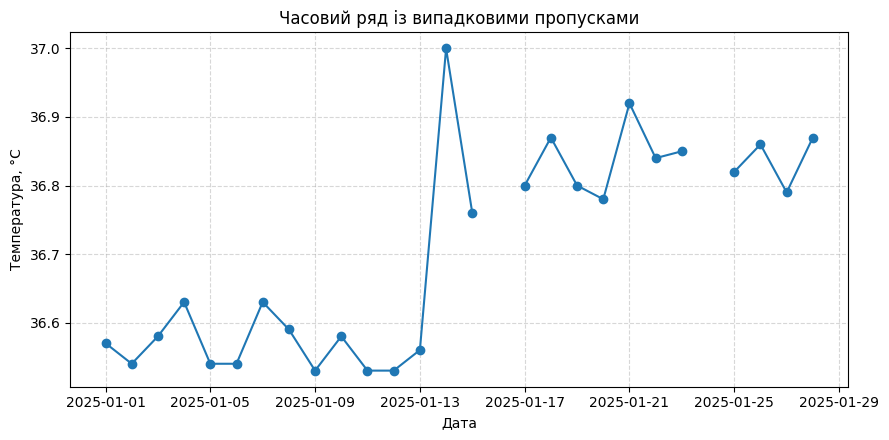

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Визначаємо кількість пропусків (5–10% від 28 точок)
n_missing = random.randint(2, 3)  # випадково 2 або 3 пропуски
missing_indices = np.random.choice(df.index, size=n_missing, replace=False)

# Копія даних із пропусками
df_missing = df.copy()
df_missing.loc[missing_indices, "bbt_celsius"] = np.nan

# Підрахунок NaN після внесення пропусків
nan_after = {
    "total_values": int(df_missing["bbt_celsius"].size),
    "nan_count": int(df_missing["bbt_celsius"].isna().sum()),
    "nan_fraction": float(df_missing["bbt_celsius"].isna().mean())
}

print("Пропуски внесено у такі індекси:", missing_indices)
print("Підсумок після внесення пропусків:", nan_after)

# Візуалізація ряду з пропусками
plt.figure(figsize=(9, 4.5))
plt.plot(df_missing["date"], df_missing["bbt_celsius"], marker="o", linestyle="-")
plt.title("Часовий ряд із випадковими пропусками")
plt.xlabel("Дата")
plt.ylabel("Температура, °C")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


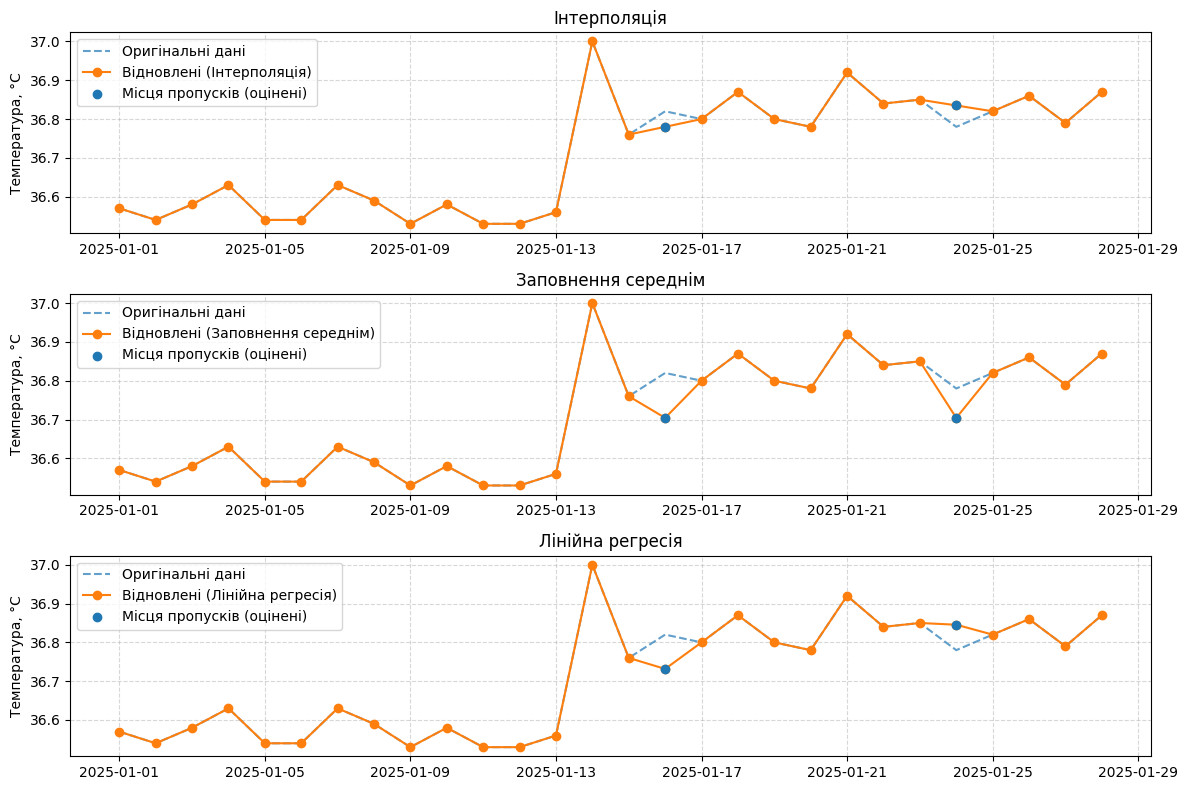

Індекси пропусків: [15 23]


,day,interp,mean_fill,regression
0,16,36.780,36.704231,36.731614
1,24,36.835,36.704231,36.845527


In [ ]:
# --- колаб-сумісна клітинка для відновлення пропусків трьома методами ---

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) df: беремо з пам'яті або читаємо з CSV
if "df" not in globals():
    # Якщо файл у Google Drive, розкоментуй:
    # from google.colab import drive
    # drive.mount('/content/drive')
    # csv_path = "/content/drive/MyDrive/bbt_cycle_28d.csv"
    csv_path = "bbt_cycle_28d.csv"   # файл у робочій теці Colab
    df = pd.read_csv(csv_path, parse_dates=["date"])

# 2) df_missing: якщо ще не створили пропуски, зробимо 2–3 випадкові
if "df_missing" not in globals():
    import random
    rng = np.random.default_rng(0)  # фіксуємо сид для відтворюваності
    n_missing = random.randint(2, 3)
    missing_indices = rng.choice(df.index, size=n_missing, replace=False)
    df_missing = df.copy()
    df_missing.loc[missing_indices, "bbt_celsius"] = np.nan
else:
    # Якщо df_missing уже є, коректно зберегти маску пропусків і їхні індекси
    missing_indices = df_missing.index[df_missing["bbt_celsius"].isna()].to_numpy()

# 3) Три методи відновлення
results = {}

# --- 3.1 Лінійна інтерполяція ---
df_interp = df_missing.copy()
df_interp["bbt_celsius"] = df_interp["bbt_celsius"].interpolate(method="linear")
results["interpolation"] = df_interp

# --- 3.2 Заповнення середнім ---
df_meanfill = df_missing.copy()
mean_val = df_meanfill["bbt_celsius"].mean(skipna=True)
df_meanfill["bbt_celsius"] = df_meanfill["bbt_celsius"].fillna(mean_val)
results["mean_fill"] = df_meanfill

# --- 3.3 Лінійна регресія (bbt ~ cycle_day) ---
try:
    from sklearn.linear_model import LinearRegression
except ImportError as e:
    raise ImportError(
        "Не знайдено scikit-learn. У Colab виконай: !pip install scikit-learn"
    ) from e

df_reg = df_missing.copy()
X = df_reg["cycle_day"].values.reshape(-1, 1)
y = df_reg["bbt_celsius"].values
mask = ~np.isnan(y)

model = LinearRegression().fit(X[mask], y[mask])
y_pred = model.predict(X)
df_reg.loc[~mask, "bbt_celsius"] = y_pred[~mask]
results["regression"] = df_reg

# 4) Візуалізація
methods = ["interpolation", "mean_fill", "regression"]
titles = ["Інтерполяція", "Заповнення середнім", "Лінійна регресія"]

plt.figure(figsize=(12, 8))
for i, method in enumerate(methods, 1):
    plt.subplot(3, 1, i)
    # оригінальний ряд (без пропусків, якщо він у тебе був до штучних NaN)
    plt.plot(df["date"], df["bbt_celsius"], label="Оригінальні дані", linestyle="--", alpha=0.7)
    # відновлений ряд
    plt.plot(results[method]["date"], results[method]["bbt_celsius"], marker="o",
             label=f"Відновлені ({titles[i-1]})")
    # позначимо місця пропусків (якщо вони є)
    nan_mask = df_missing["bbt_celsius"].isna()
    if nan_mask.any():
        plt.scatter(df_missing.loc[nan_mask, "date"],
                    results[method].loc[nan_mask, "bbt_celsius"],
                    label="Місця пропусків (оцінені)", zorder=5)
    plt.title(titles[i-1])
    plt.ylabel("Температура, °C")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend()

plt.tight_layout()
plt.show()

# 5) Таблиця порівняння значень у точках пропусків
nan_mask = df_missing["bbt_celsius"].isna()
comparison = pd.DataFrame({
    "day": results["interpolation"].loc[nan_mask, "cycle_day"].to_numpy(),
    "interp": results["interpolation"].loc[nan_mask, "bbt_celsius"].to_numpy(),
    "mean_fill": results["mean_fill"].loc[nan_mask, "bbt_celsius"].to_numpy(),
    "regression": results["regression"].loc[nan_mask, "bbt_celsius"].to_numpy(),
})
comparison.reset_index(drop=True, inplace=True)

print("Індекси пропусків:", missing_indices)
comparison


Висновок

У ході лабораторної роботи було згенеровано синтетичний часовий ряд базальної температури жінки протягом 28-денного менструального циклу. Початково пропуски були відсутні, тому штучно внесено близько 7% пропусків у дані.

Було застосовано три методи їх відновлення:

Лінійна інтерполяція – забезпечила плавне відновлення та збереження тренду.

Заповнення середнім значенням – дало менш точні результати, оскільки не враховує сезонність і тренд, а лише вирівнює дані.

Лінійна регресія – показала результат, дуже близький до інтерполяції, адекватно відтворюючи очікувану динаміку.

Отже, для подібних даних найбільш доцільно використовувати лінійну інтерполяцію або лінійну регресію, оскільки ці методи краще зберігають характерні коливання часових рядів, пов’язані з біологічними процесами.